In [1]:
import torch
from data import CIFAR10DataModule
import biopytorch.biolinear as biolinear
import biopytorch.biotrainer as bio_train
from plotting import plot_rgb_filters
from biopytorch.bioconv2d import BioConv2d
from biopytorch.biotrainer import bio_train
from plotting import plot_rgb_filters
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, lr_scheduler
from tqdm.notebook import tqdm
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from time import time
from ignite.metrics import Accuracy, Loss
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup, LRScheduler
from torchvision import transforms
from torch.utils.data import DataLoader
from biopytorch.biolinear import BioLinear
from plotting import plot_rgb_filters
from biopytorch.biotrainer import bio_train
import torchvision

In [2]:
print("Torch version:", torch.__version__)

#Select device for training
#device = "cpu" #For this very simple dataset it is actually faster
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #Uncomment for GPU 

print(f'Using "{device}" for training')

Torch version: 1.12.0
Using "cpu" for training


In [3]:
#composed_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomResizedCrop(32)])
cifar10 = CIFAR10DataModule(batch_size = 64)#, train_data_transform = composed_transform)
cifar10.setup()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#composed_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomResizedCrop(32)])
data_dir = '../../data/project/'
train_dataset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.CIFAR10(data_dir, train=False, download=True)

train_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Lambda(lambda x: torch.flatten(x))
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def plot_filters_callback(weights):
    plot_rgb_filters(weights[:5])

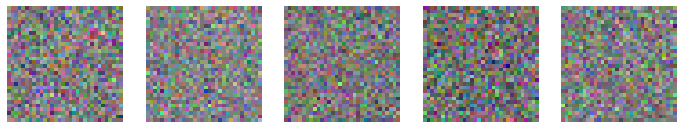

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

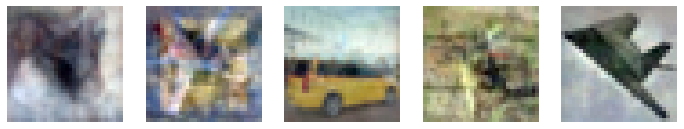

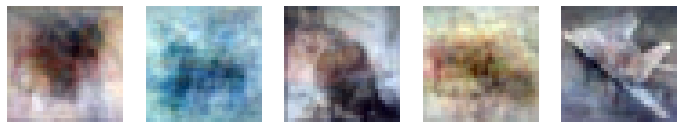

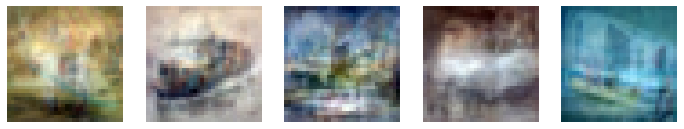

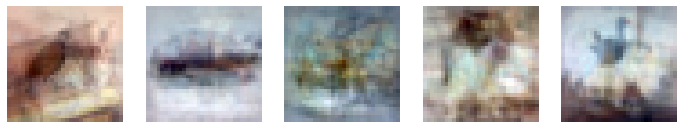

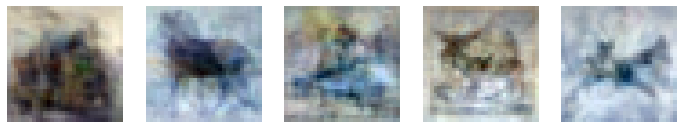

array(0.3829891, dtype=float32)

In [7]:
biolinear = BioLinear(3 * 32 * 32, 200, bias = True, delta=.1, ranking_param=2, lebesgue_p=2)

def plot_filters_callback(weights):
    """
    Plot the first 5 weights
    """
    
    plot_rgb_filters(weights[:5].reshape(5, 3, 32, 32))

plot_filters_callback(biolinear.weight.cpu()) #Initial filters

bio_train(biolinear, cifar10, n_epochs=5, epoch_callback=plot_filters_callback, lr_scheduler=(.1, .001, .3),\
    device = device)

In [33]:
#torch.save(biolinear.weight, "../../data/project/weightsCIFARfc")
#weightsCIFARfc = torch.load("../../data/project/weightsCIFARfc")
weightsCIFARfc = biolinear.weight 

In [34]:
train_transform = transforms.Compose([transforms.Lambda(lambda x: torch.flatten(x))])
cifar10.transform = train_transform

In [35]:
class BioNet(nn.Module):
    def __init__(self,
                 weights : torch.Tensor,
                 output_dim : int,
                 n : float = 4.5,
                 beta : float =.01):
        
        """
        Simple MNIST classifier initialized with weights from the unsupervised (bio)learning algorithm for the first layer.
        
        Parameters
        ----------
        weights : torch.Tensor of shape (output_dim, input_dim), where input_dim = 28*28 for the MNIST dataset
            Weights computed from unsupervised learning.
        output_dim : int
            Number of classes (10 for MNIST)
        n : float
            Exponent of ReLU
        beta : float
            "Inverse temperature" for tanh activation in the top layer (See equation 1 in [10]).
        """
        
        super().__init__()
        self.weights = torch.t(weights) #shape (output_dim, input_dim) -> (input_dim, output_dim)
        #[Because batch_size is the first dimension of inputs, and so it is convenient to transpose the weights
        #so that a single matrix multiplication works for the entire batch]
        
        self.n = n
        self.beta = beta
        # The .size method is equivalent to .shape in numpy
        self.top = nn.Linear(in_features = weights.size(0), out_features = output_dim, bias=False)
    
        
    def forward(self, inputs : torch.Tensor): # vᵢ: (batch_sz, img_sz)
        """
        Parameters
        ----------
        inputs : torch.Tensor of shape (batch_size, input_dim)
            Batch of input values
        """
        
        out = torch.matmul(inputs, self.weights) 
        out = F.relu(out) #** self.n
        out = self.top(out)
        #out = torch.tanh(self.beta * out)
        
        return out
    
class BioLoss(nn.Module):
    """Loss introduced in eq. 12 of [1]
    
    [1]: "Unsupervised learning by competing hidden units", D. Krotov, J. J. Hopfield, 2019, 
         https://www.pnas.org/content/116/16/7723
    """
    
    def __init__(self,
                 output_dim : int = 10,
                 m : int = 6):
        
        super().__init__()
        
        self.output_dim = output_dim
        self.m = m

    def forward(self, predicted, true_val): 
        one_hot = torch.eye(self.output_dim, dtype=torch.float, device=predicted.device)[true_val]
        #Convert true values to one hot encoding
        one_hot[one_hot == 0] = -1 #Substitute 0s with -1 (spin-like one hot encoding)
        
        loss = (predicted - one_hot).abs() ** self.m
        
        return torch.sum(loss)

In [36]:
def run_test(train_dl, test_dl, model, epochs, loss, batch_size=64, lr=1e-3, verbose=0):
    #From https://github.com/gatapia/unsupervised_bio_classifier/blob/master/src/bio_learn2.py
    #(Standard training code)
    
    start = time()
    train_dl = train_dl
    test_dl = test_dl
        
    optimizer = Adam(model.parameters(), lr=lr)    
    #create_supervised_trainer is a factory function (a function that returns a new object) for creating a trainer for supervised models
    trainer = create_supervised_trainer(model, optimizer, loss)
    evaluator = create_supervised_evaluator(model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss)})
    
    pbar = tqdm(initial=0, leave=False, total=epochs, desc=f"ITERATION") #Progress bar
    
    train_err = []
    test_err  = []
    
    # Basic usage of ignite's create_supervised_trainer function

    #EPOCH_COMPLETED : triggered when the epoch is ended. Note that this is triggered even when terminate_epoch() is called.
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_epoch(trainer):
        evaluator.run(train_dl)
        metrics = evaluator.state.metrics
        train_acc = metrics['accuracy']
        
        evaluator.run(test_dl)
        metrics = evaluator.state.metrics
        test_acc = metrics['accuracy']
        
        train_err.append( 100 * (1. - train_acc) )
        test_err.append( 100 * (1. - test_acc ) )
        
        pbar.desc = f"ITERATION - accuracy (train): {train_acc:.3f} - accuracy (test) : {test_acc:.3f}"
        pbar.update(1)

    # COMPLETED : triggered when engine’s run is completed
    @trainer.on(Events.COMPLETED)
    def log_complete(engine):
        evaluator.run(test_dl)        
        print("Final Accuracy: {:.2f} Took: {:.0f}s".format(evaluator.state.metrics['accuracy'], time() - start))

    trainer.run(train_dl, max_epochs=epochs) 
    
    return train_err, test_err

In [37]:
loss = nn.CrossEntropyLoss()  

In [38]:
#Supervised training of top layer
n_classes = 10
model = BioNet(weightsCIFARfc.float(), n_classes, beta=.001)#.cuda() #Remove .cuda() everywhere in this line to train on CPU only
train_err, test_err = run_test(train_dataloader, test_dataloader, model, epochs=30,\
    loss=loss, batch_size=64, lr=1e-4)  

ITERATION:   0%|          | 0/30 [00:00<?, ?it/s]

Engine run is terminating due to exception: 


KeyboardInterrupt: 

In [ ]:
64*32

2048